## Estimating noise and stabilizing variance in calcium imaging data

The purpose of this notebook is to show how to use the VST transform for estimating the noise profile of calcium imaging data and apply a generalized Anscombe transform that aims to transform the noise into white Gaussian.

In [1]:
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
import timeit
import numpy as np
import os
import caiman.external.houghvst.estimation as est
from caiman.external.houghvst.gat import compute_gat, compute_inverse_gat
import caiman as cm
import matplotlib.pyplot as plt
from caiman.paths import caiman_datadir

Below is a function that will compute and apply the transformation and its inverse. The underlying noise model is scaled Poisson plus Gaussian, i.e., the underlying fluorescence value $x$ is related to the observed value $y$ by the equation

$$y = \alpha*\text{Poisson}(x) + \varepsilon$$

where $\alpha$ is non-negative scalar, and $\varepsilon \sim \mathcal{N}(\mu,\sigma^2)$ is distributed according to a Gaussian distribution.

In [2]:
def main():
    fnames = [os.path.join(caiman_datadir(), 'example_movies', 'demoMovie.tif')]

    movie = cm.load(fnames)
    movie = movie.astype(np.float)

    # makes estimation numerically better:
    movie -= movie.mean()

    # use one every 200 frames
    temporal_stride = 100
    # use one every 8 patches (patches are 8x8 by default)
    spatial_stride = 6

    movie_train = movie[::temporal_stride]

    t = timeit.default_timer()
    estimation_res = est.estimate_vst_movie(movie_train, stride=spatial_stride)
    print('\tTime', timeit.default_timer() - t)

    alpha = estimation_res.alpha
    sigma_sq = estimation_res.sigma_sq

    movie_gat = compute_gat(movie, sigma_sq, alpha=alpha)
    # save movie_gat here
    movie_gat_inv = compute_inverse_gat(movie_gat, sigma_sq, alpha=alpha,
                                        method='asym')
    # save movie_gat_inv here
    return movie, movie_gat, movie_gat_inv

In [3]:
movie, movie_gat, movie_gat_inv = main()

100%|██████████| 1/1 [00:00<00:00, 30.01it/s]


	initial alpha = 152.07096181799562; sigma^2 = 110377.61727714511
	Highest score= 122.072110562
	mid alpha = 76.03548090899781; sigma^2 = 93653.73587151707
	Highest score= 125.025632373
	alpha = 81.91094988832947; sigma^2 = 92873.28807258776
	Time 36.398378915997455


The transformed movie should have more uniform dynamic range (press `q` to exit):

In [4]:
movie_gat.play(magnification=4, q_max=99.8)

The movie might appear more noisy but information is preserved as seen from the correlation image:

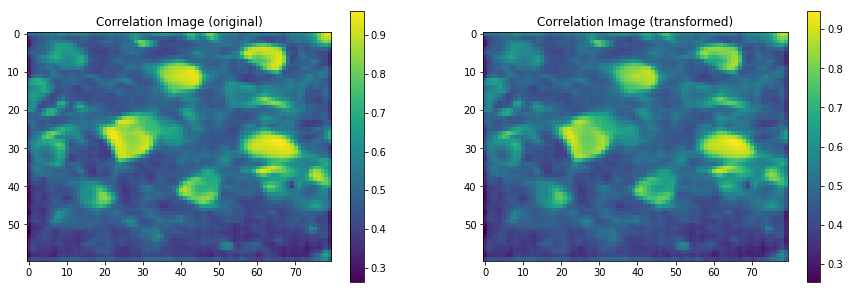

In [5]:
CI = movie.local_correlations(swap_dim=False)
CI_gat = movie_gat.local_correlations(swap_dim=False)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1); plt.imshow(CI); plt.colorbar(); plt.title('Correlation Image (original)')
plt.subplot(1,2,2); plt.imshow(CI_gat); plt.colorbar(); plt.title('Correlation Image (transformed)')

The noise estimates in space should also be more uniform

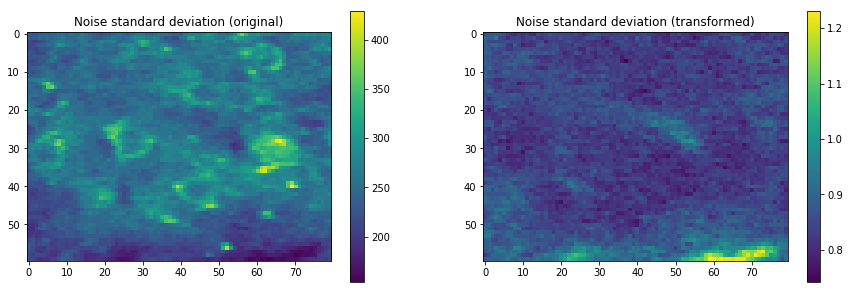

In [6]:
sn = cm.source_extraction.cnmf.pre_processing.get_noise_fft(movie.transpose(1,2,0), noise_method='mean')[0]
sn_gat = cm.source_extraction.cnmf.pre_processing.get_noise_fft(movie_gat.transpose(1,2,0), noise_method='mean')[0]
# sn = np.std(movie.transpose(1,2,0), axis=-1)
# sn_gat = np.std(movie_gat.transpose(1,2,0), axis=-1)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1); plt.imshow(sn); plt.colorbar(); plt.title('Noise standard deviation (original)')
plt.subplot(1,2,2); plt.imshow(sn_gat); plt.colorbar(); plt.title('Noise standard deviation (transformed)')

If we apply the inverse transform we approximately get back the original movie (press `q` to exit):

In [7]:
cm.concatenate([movie,movie_gat_inv],axis=2).play(magnification=5, q_max=99.5)